<a href="https://colab.research.google.com/github/colinjhorgan/MLTSA22_CHorgan/blob/main/HW3/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [237]:
import numpy as np
import pandas as pd
import pylab as plt
import glob
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta as td
from scipy.stats import pearsonr

#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [238]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [239]:
cd /content/gdrive/MyDrive/kaggle/HW2/data

/content/gdrive/MyDrive/kaggle/HW2/data


In [240]:
#store first 10 stock files in numpy array, sorted alphabetically
file_list = np.sort(np.array(glob.glob('Data/Stocks/*.txt')))[:10]

In [241]:
#Read top 10 files in, keeping only Date and Close columns.
tss = pd.read_csv(file_list[0])[['Date','Close']]

for i in range(1,10):
  df = pd.read_csv(file_list[i])[['Date','Close']]
  tss = tss.merge(df, on='Date')

tss.set_index('Date', inplace=True)

#Rename columns to reflect respective stock closing value
cols = []

for i in range(0,10):
  cols.append(file_list[i].split('/')[-1].replace('.txt',''))

tss.columns = cols

# 1. Why is significance threshold set to 0.05? What does it mean?

Significance threshold is set to p=0.05 as it is a standard of 'statistical significance' which has been well established and accepted by the scientific community (there's some debate about this threshold, especially around modifying it depending on the size of your sample etc etc but that's beyond the scope here). The p-value reflects our likelihood of type 1 error, that is, the likelihood that we reject the null hypothesis and the null hypothesis is actually true. For the Augmented Dickey Fuller test, the null hypothesis is that a unit root is present within a given time series. With a p-value cutoff of 0.05, 
this means that the probability of type 1 error must be less than 5% in order for us to reject the null hypothesis and conclude that the given time series lacks a unit root and is therefore stationary.


# 2. Plotting Autocorrelation and Partial Autocorrelation Functions

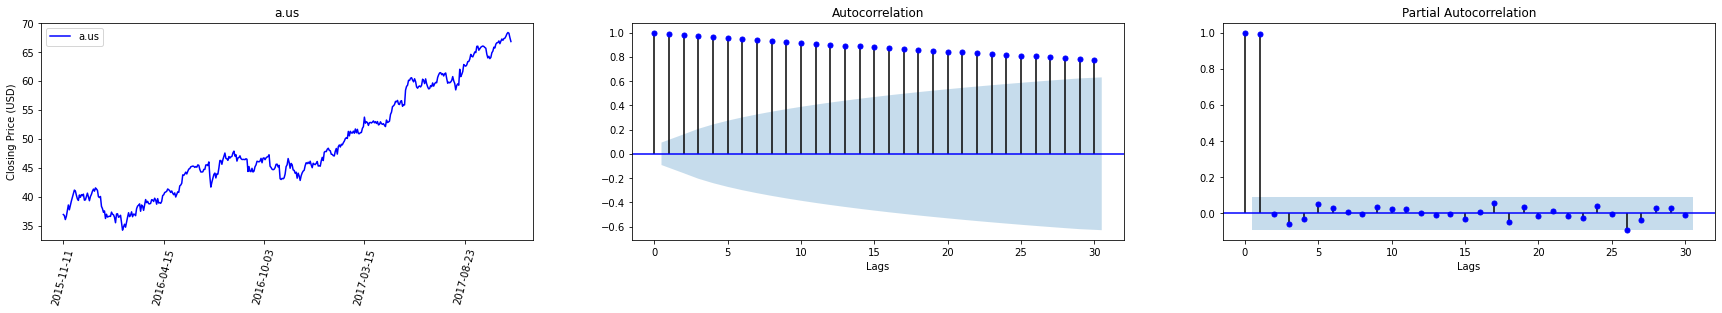

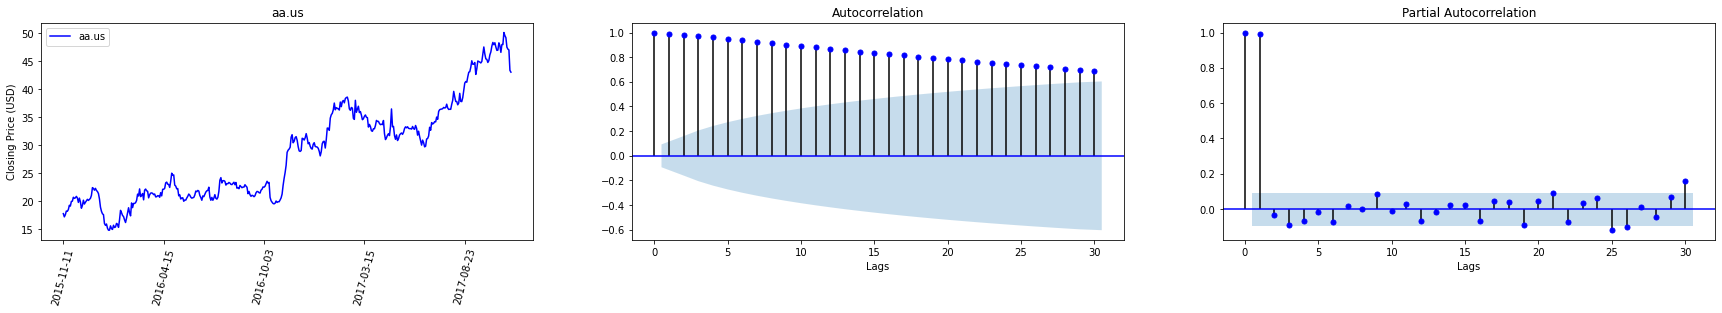

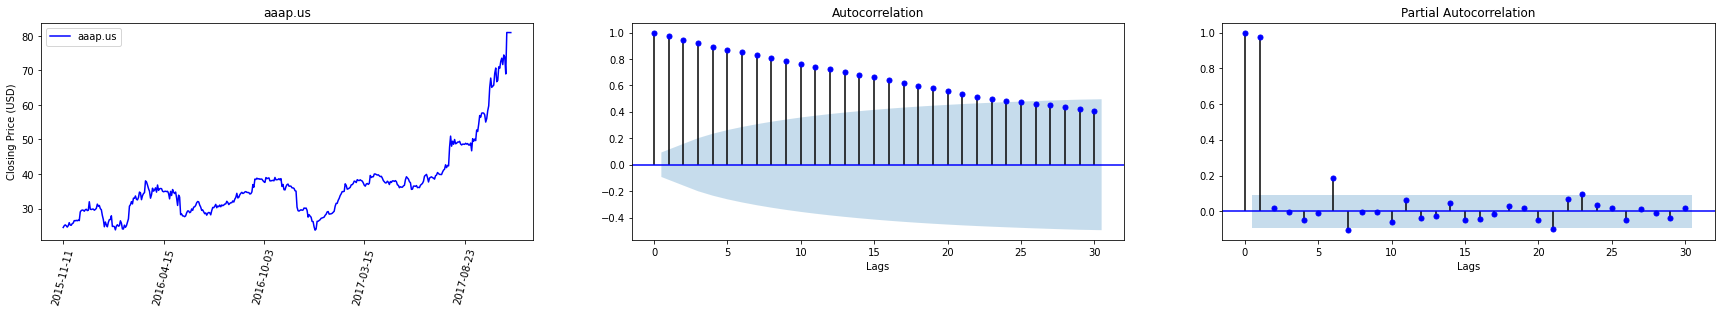

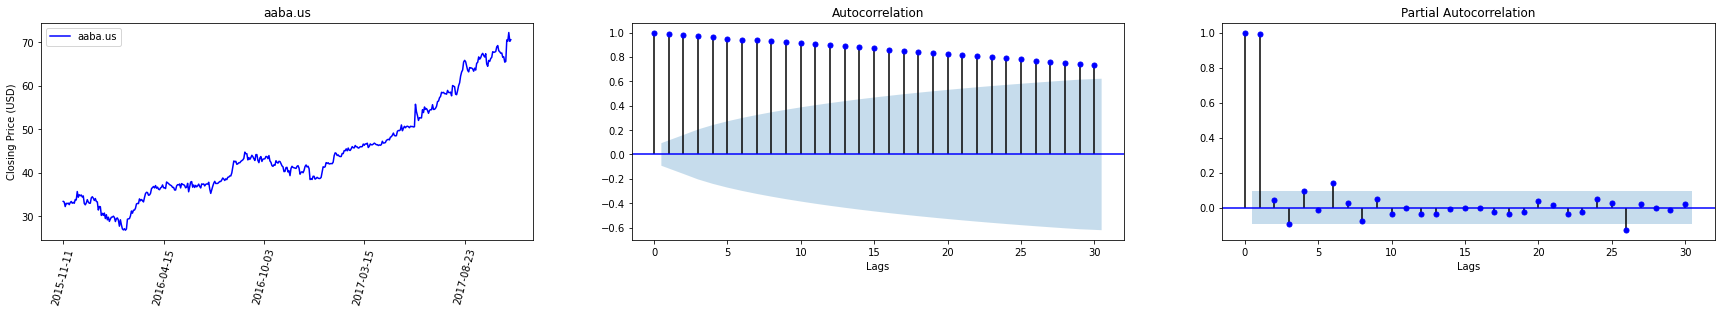

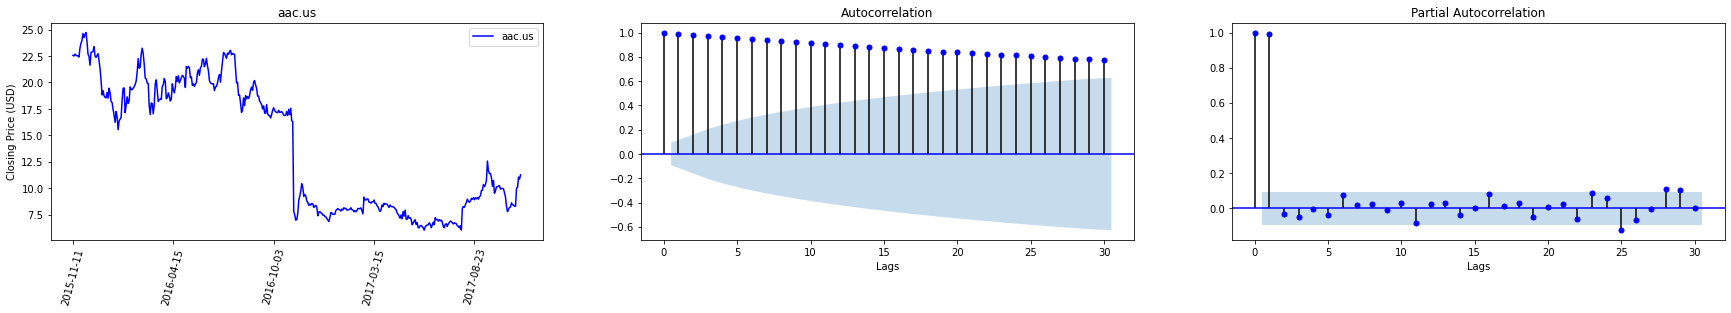

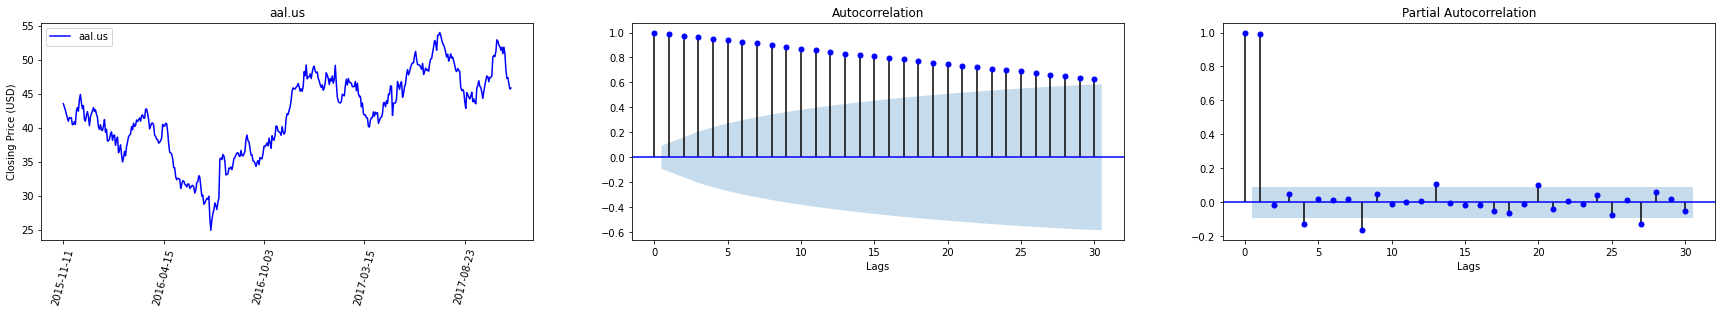

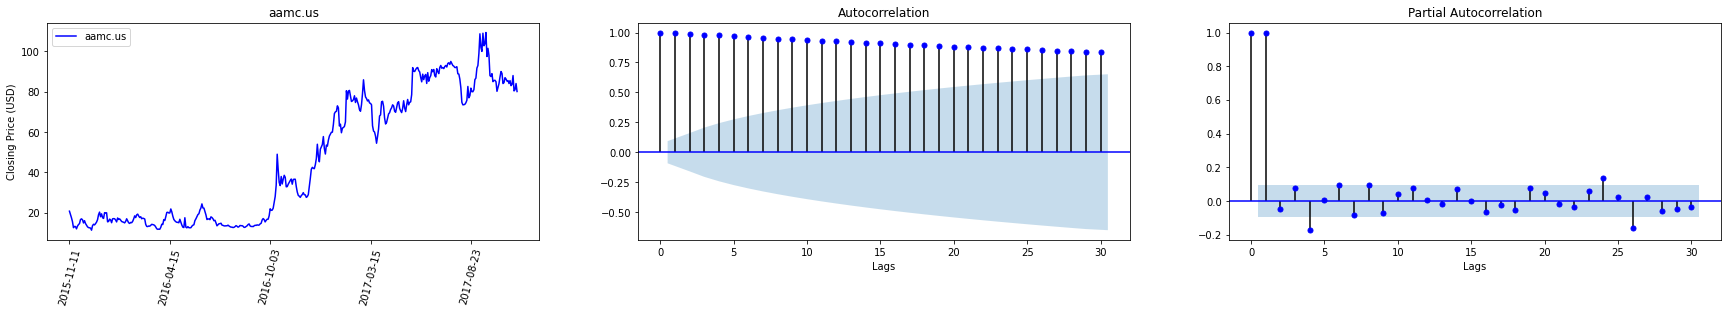

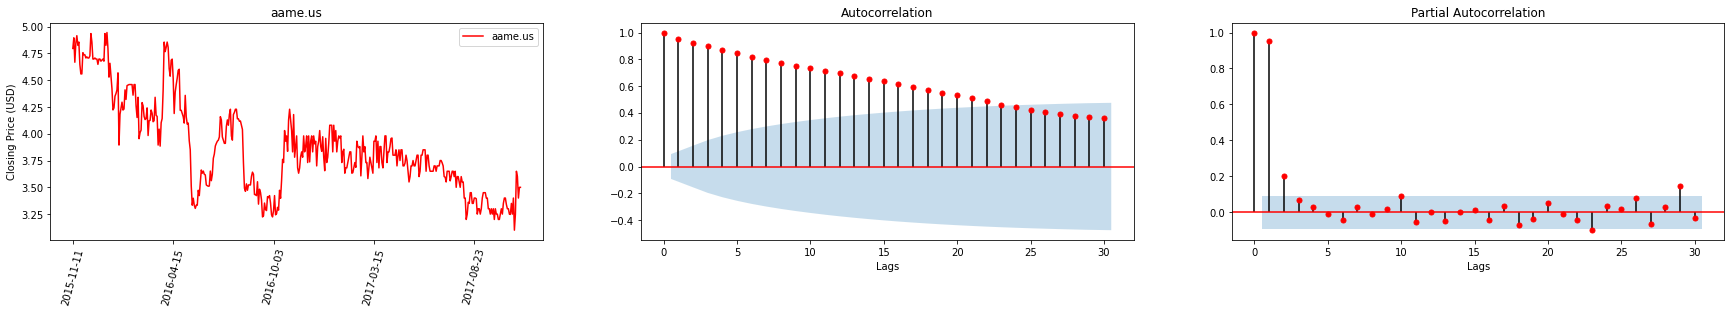

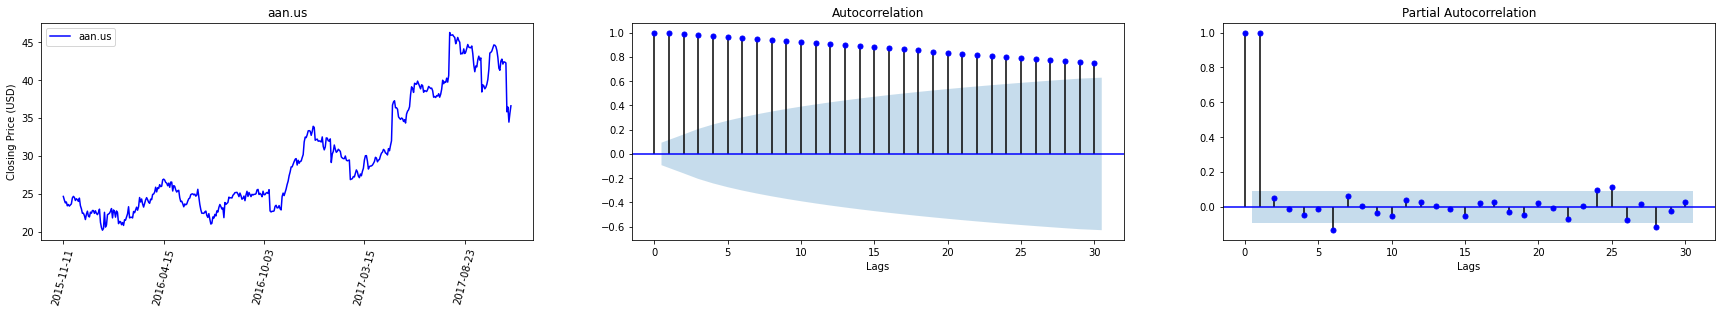

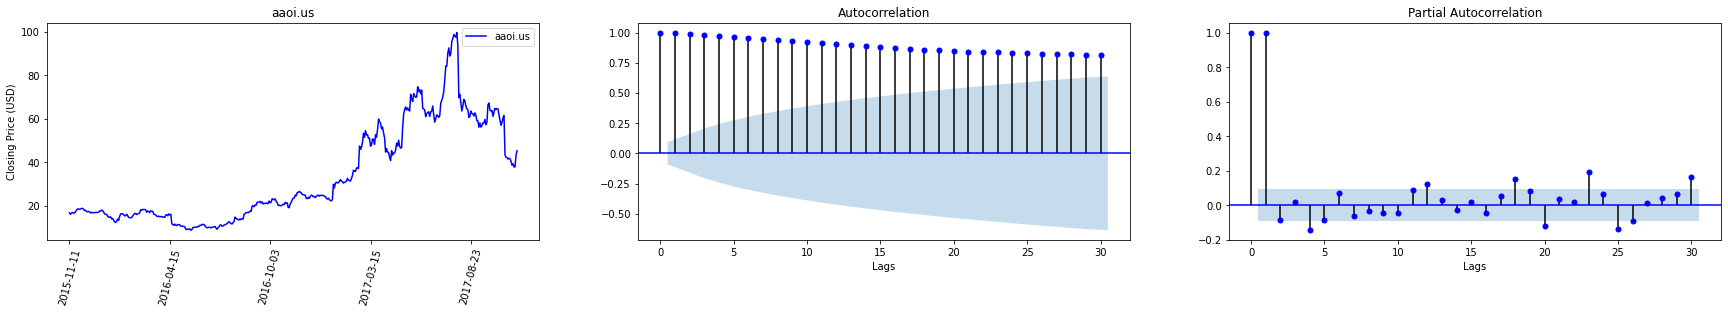

In [242]:
#Test for stationarity
for col in tss:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,4))
  result =  sm.tsa.stattools.adfuller(tss[col])

  #if stationary plot as red, else plot as blue
  color = 'blue'
  if result[1] < 0.05: 
    color = 'red'
  
  tss.plot(y=col, rot=75, color=color, ax=ax1); #plot closing price
  ax1.set_title(f'{col}')
  ax1.set_ylabel('Closing Price (USD)')
  ax1.set_xlabel('')

  plot_acf(tss[col], lags=30, color=color, ax=ax2); #plot acf
  ax2.set_xlabel('Lags')

  plot_pacf(tss[col], lags = 30, color=color, ax=ax3); #plot pacf
  ax3.set_xlabel('Lags')

Figure 1: Time series, autocorrelation function, and partial autocorrelation function plots for all 10 of our selected stocks. Time series which are stationary (Augmented Dickey Fuller, p-value < 0.05) are plotted in red, otherwise they are plotted in blue.

#3. A.us Significant Lags ACF and PACF
For our first stock 'a.us' the first 30 lags are expected to be significant in the autocorrelation function (which suggests we should apply some differencing, probably a first difference). In the partial autocorrelation function lags 1, 2, and 26 are expected to be significant.

# 4. Train Test Split

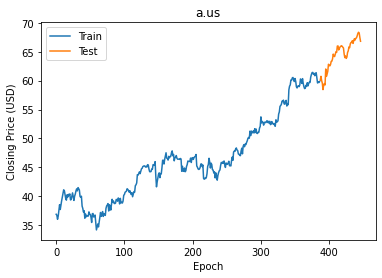

In [243]:
plt.figure()
plt.plot(tss['a.us'].values[:-60])
plt.plot(np.arange(tss.shape[0] - 60, tss.shape[0]), tss['a.us'].values[-60:])
plt.legend(['Train', 'Test'])
plt.title('a.us')
plt.ylabel('Closing Price (USD)')
plt.xlabel('Epoch');

Figure 2: Visualization of a train-test split over a.us.

#5. Fit ARMA to Stationary Time Series

The only time series Dickey-Fuller revealed as 'stationary' is aame.us, therefore we will fit ARMA to that stock.

In [244]:
#The PACF of aame.us suggests the 'q' parameter should be around 3, but since 
#the ARMA process is fairly quick we will expand the search space to p,q = [0,5]

aic = np.zeros((6,6))

for p in range(6):
  for q in range(6):
    try:
      mod = sm.tsa.ARMA(tss['aame.us'][:-60], (p,q)).fit()
      aic[p, q] = mod.aic
    except: 
      aic[p, q] = np.nan

#parameters of best-fit model are the ith, jth index of the min AIC
p, q = np.argwhere(aic == np.nanmin(aic))[0]
print(f'Best Parameters for ARMA Model\np: {p}\nq: {q}\nAIC: {aic[p,q]}')


Best Parameters for ARMA Model
p: 3
q: 3
AIC: -490.650728955653


# 6. Predict Values on Training Set

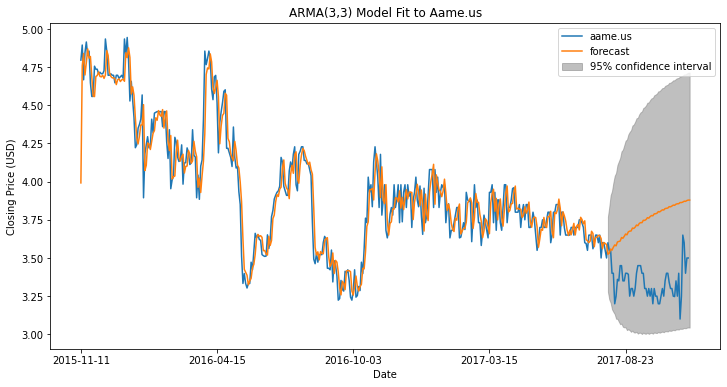

In [245]:
#plot predictions of best-fit model
mod = sm.tsa.ARMA(tss['aame.us'][:-60], (3,3)).fit()

ax = tss['aame.us'].plot(figsize=(12,6));
mod.plot_predict(end=tss['aame.us'][:-60].shape[0] + 60, plot_insample=False, ax=ax);
ax.set_ylabel('Closing Price (USD)')
ax.set_title('ARMA(3,3) Model Fit to Aame.us');


Figure 3: Forecast of best fit model (ARMA(3,3)) to 60 timesteps beyond the training set. Model minimizes AIC with p,q within [0,5]

# 7. Did we make any money?

Although the actual stock price in the testing set was below our model's forecasted mean, the real values still reside within a 95% confidence interval. This means that - assuming we traded based off of this interval - we could have made a profit.

# Coefficients of Best Fit Model and What They Mean

In [246]:
#Print ARMA(3,3) summary
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                aame.us   No. Observations:                  387
Model:                     ARMA(3, 3)   Log Likelihood                 253.325
Method:                       css-mle   S.D. of innovations              0.125
Date:                Tue, 01 Mar 2022   AIC                           -490.651
Time:                        02:19:16   BIC                           -458.983
Sample:                             0   HQIC                          -478.094
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9919      0.183     21.764      0.000       3.632       4.351
ar.L1.aame.us    -0.3639      0.036    -10.171      0.000      -0.434      -0.294
ar.L2.aame.us     0.3646      0.033     11.185      0.000       0.301       0.429
ar.L3.aame.us     0.9217      0.052     17.763      0.000       0.820       1.023
ma.L1.aame.us     1.0918      0.068     16.163      0.000       0.959       1.224
ma.L2.aame.us     0.6290      0.087      7.242      0.000       0.459       0.799
ma.L3.aame.us    -0.2646      0.054     -4.860      0.000      -0.371      -0.158
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0242           -0.0000j            1.0242           -0.0000
AR.2           -0.7099           -0.7452j            1.0292           -0.3711
AR.3           -0.7099           +0.7452j            1.0292            0.3711
MA.1           -0.6851           -0.7342j            1.0043           -0.3695
MA.2           -0.6851           +0.7342j            1.0043            0.3695
MA.3            3.7472           -0.0000j            3.7472           -0.0000
-----------------------------------------------------------------------------
"""

In [247]:
#Print model coefficients
print(mod.params)

const            3.991909
ar.L1.aame.us   -0.363935
ar.L2.aame.us    0.364624
ar.L3.aame.us    0.921722
ma.L1.aame.us    1.091824
ma.L2.aame.us    0.628956
ma.L3.aame.us   -0.264609
dtype: float64


The coefficients of our best-fit model are shown above. The number of the coefficient (ex: L1, L2, L3) refers to the lag to which the coefficient is applied. Coefficients leading with 'ar' are the autoregressive coefficients and those leading with 'ma' are the moving average coefficients. As seen in our model summary, all coefficients are highly significant.



#9. Fit ARIMA to 2 Uncorrelated Non-Stationary Time Series

In [248]:
#We will select 2 time series which are not correlated to each other
cor_mat = np.zeros((10,10))
cor_mat[:] = np.nan

for i in range(10):
  for j in range(i+1): #avoid duplicates by only calculating the lower diagonal
    cor_mat[i,j] = pearsonr(tss.iloc[:,i], tss.iloc[:,j])[0]

pd.DataFrame(cor_mat, columns=tss.columns, index=tss.columns)

#Based on Pearson's R we will choose aal.us and aaap.us (r = 0.452)

,a.us,aa.us,aaap.us,aaba.us,aac.us,aal.us,aamc.us,aame.us,aan.us,aaoi.us
a.us,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aa.us,0.902139,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaap.us,0.800310,0.776600,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaba.us,0.973457,0.904210,0.872134,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
aac.us,-0.721867,-0.791137,-0.423021,-0.670578,1.000000,NaN,NaN,NaN,NaN,NaN
aal.us,0.621041,0.713229,0.451520,0.612989,-0.785248,1.000000,NaN,NaN,NaN,NaN
aamc.us,0.897263,0.893952,0.621329,0.849972,-0.868936,0.780517,1.000000,NaN,NaN,NaN
aame.us,-0.699609,-0.606774,-0.573976,-0.709023,0.510986,-0.219258,-0.544740,1.000000,NaN,NaN
aan.us,0.905395,0.873520,0.696179,0.903785,-0.765267,0.756808,0.881631,-0.585002,1.000000,NaN
aaoi.us,0.851239,0.766459,0.560427,0.809059,-0.780147,0.746505,0.904166,-0.496371,0.860847,1.0


Table 1: Pairwise measures of pearson's correlation coefficient across all 10 stocks. To avoid duplicate computations only correlations below the diagonal were calculated.

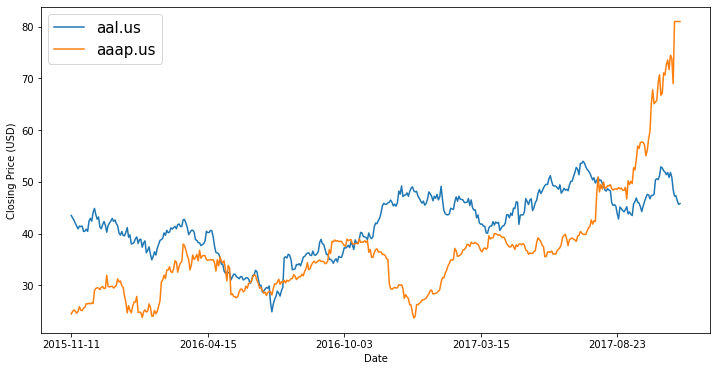

In [249]:
#Plot both time series
plt.figure(figsize=(12,6))
tss['aal.us'].plot()
tss['aaap.us'].plot()
plt.legend(prop={'size':15})
plt.ylabel('Closing Price (USD)');

Figure 4: Closing price of two stocks with low correlation coefficient.

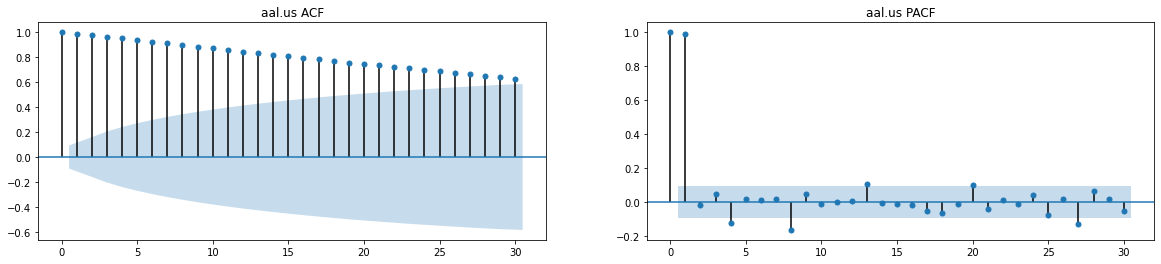

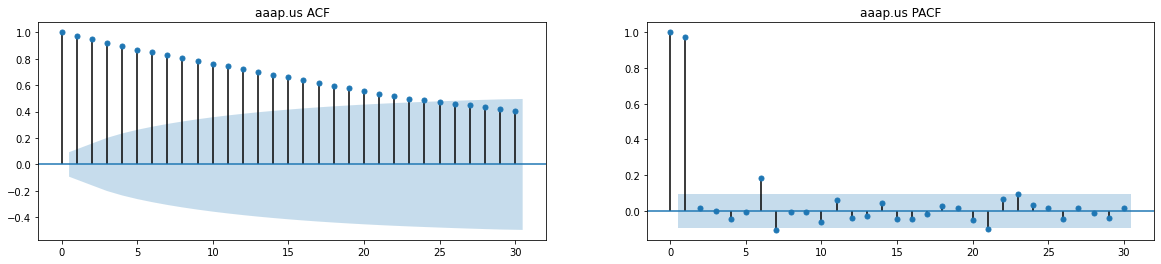

In [250]:
#Plot ACF and PACF
for col in ['aal.us', 'aaap.us']:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4))
  
  plot_acf(tss[col], lags=30, ax=ax1)
  ax1.set_title(f'{col} ACF')

  plot_pacf(tss[col], lags=30, ax=ax2)
  ax2.set_title(f'{col} PACF')

Figure 5: Autocorrelation and partial autocorrelation plots for aal.us and aaap.us. Shaded areas indicate 95% confidence interval. Only the first 30 lags are shown.

Since we know neither time series is stationary, we will restrict the search space of 'd' to (1,2). ARIMA in statsmodels does not support d>2. We will let p and q range from 0 to 4. There are other significant lags in the PACF of both stocks but I am restricting hyperparameters to save on compute time.

In [251]:
#Using aal.us, fit ARIMA models and minimize over AIC

aic = np.zeros((5,2,5))

for d in range(1,3):
  for p in range(5):
    for q in range(5):
      try:
        aic[p,d-1,q] = sm.tsa.ARIMA(tss['aal.us'][:-60], order=(p,d,q)).fit().aic
      except:
        aic[p,d-1,q] = np.nan

aic[0,0,0] = np.nan #remove ARIMA(0,1,0) from consideration
p, d, q = np.argwhere(aic == np.nanmin(aic))[0]

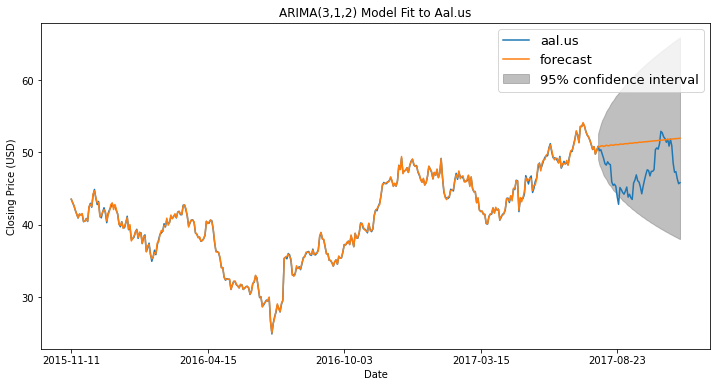

In [252]:
#Plot model forecast
mod = sm.tsa.ARIMA(tss['aal.us'][:-60], order=(p,d+1,q)).fit()

ax = tss['aal.us'].plot(figsize=(12,6));
mod.plot_predict(end=tss['aal.us'][:-60].shape[0] + 60, plot_insample=False, ax=ax);
ax.set_ylabel('Closing Price (USD)')
ax.set_title(f'ARIMA({p},{d+1},{q}) Model Fit to Aal.us');
plt.legend(prop={'size': 13});

Figure 6: Model predictions of ARIMA(3,1,2) on testing data. Model minimizes AIC with p,q within [0,4], d within [1,2] 

In [253]:
#Using aaap.us, fit ARIMA models and minimize over AIC

aic = np.zeros((5,2,5))

for d in range(1,3):
  for p in range(5):
    for q in range(5):
      try:
        aic[p,d-1,q] = sm.tsa.ARIMA(tss['aaap.us'][:-60], order=(p,d,q)).fit().aic
      except:
        aic[p,d-1,q] = np.nan

aic[0,0,0] = np.nan #remove ARIMA(0,1,0) from consideration
p, d, q = np.argwhere(aic == np.nanmin(aic))[0]

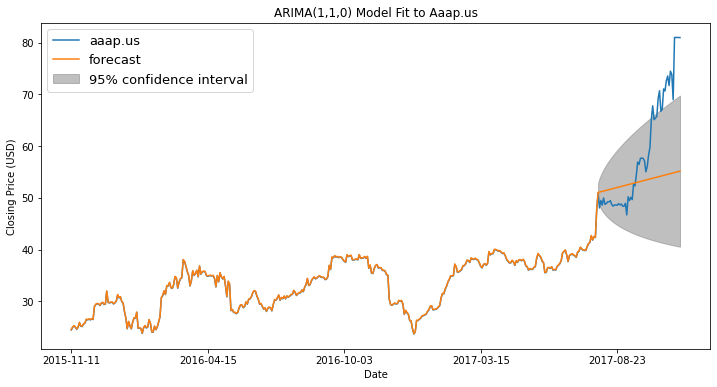

In [254]:
#Plot model forecast
mod = sm.tsa.ARIMA(tss['aaap.us'][:-60], order=(p,d+1,q)).fit()

ax = tss['aaap.us'].plot(figsize=(12,6));
mod.plot_predict(end=tss['aaap.us'][:-60].shape[0] + 60, plot_insample=False, ax=ax);
ax.set_ylabel('Closing Price (USD)')
ax.set_title(f'ARIMA({p},{d+1},{q}) Model Fit to Aaap.us');
plt.legend(prop={'size': 13});

Figure 7: Model predictions of ARIMA(1,1,0) on testing data. Model minimizes AIC with p,q within [0,4], d = [1,2]

# 10. Did we get rich?

For aal.us, we found that an ARIMA(3,1,2) model minimized AIC. When comparing this model's forecast to the out-of-sample data we see that all held-out data falls within our model's 95% confidence interval (there may be an exception at one data point around 2017-08-23. We could make money on this stock if we traded according to our 95% confidence interval.

For aaap.us, we gound that an ARIMA(1,1,0) model minimized AIC. This model performed poorly when forecasting over the test data. This is likely due to some event which occured around 2017-08-23 which caused a steep increase in the price of the stock. ARIMA models are not robust against such events and so this failure is understandable. If we were trading using this model we may have been in a position to lose some money, depending on how aggressive we were trading.

# 11. Redo model fit with a different order of differencing

We will use aal.us to use a different choice of 'd' since that model has more parameters.

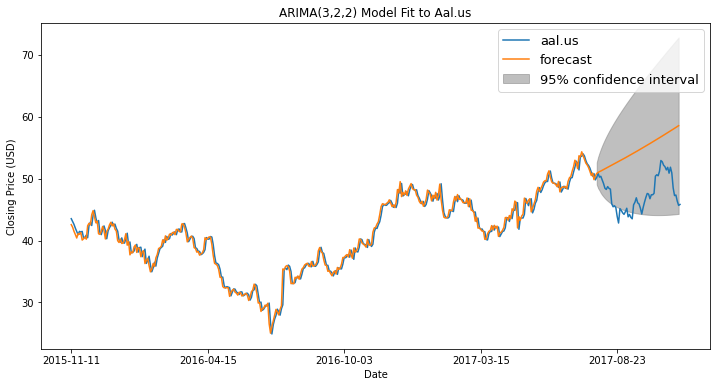

In [255]:
#Re-fit original model as well as new model with different 'd'
mod1 = sm.tsa.ARIMA(tss['aal.us'][:-60], order=(3,1,2)).fit()
mod2 = sm.tsa.ARIMA(tss['aal.us'][:-60], order=(3,2,2)).fit()

#Plot new model predictions
plt.figure()
ax = tss['aal.us'].plot(figsize=(12,6));
mod2.plot_predict(end=tss['aal.us'][:-60].shape[0] + 60, plot_insample=False, ax=ax);
ax.set_ylabel('Closing Price (USD)')
ax.set_title(f'ARIMA(3,2,2) Model Fit to Aal.us');
plt.legend(prop={'size': 13});

Figure 8: Model predictions of ARIMA(3,2,2) on testing data. Note that model was generated for experimental purposes and not due to any statistical criteria.

In [256]:
#Examine model coefficients and p-values
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.aaap.us   No. Observations:                  386
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -528.052
Method:                       css-mle   S.D. of innovations              0.950
Date:                Tue, 01 Mar 2022   AIC                           1062.104
Time:                        02:20:14   BIC                           1073.972
Sample:                             1   HQIC                          1066.810
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0686      0.049      1.414      0.158      -0.026       0.164
ar.L1.D.aaap.us     0.0030      0.052      0.058      0.953      -0.098       0.104
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          331.5747           +0.0000j          331.5747            0.0000
-----------------------------------------------------------------------------
"""

In [257]:
#compare coefficient p-values between models
print('ARIMA(3,1,2) p-values')
print(mod1.pvalues)
print('\nARIMA(3,2,2) p-values')
print(mod2.pvalues)

ARIMA(3,1,2) p-values
const             6.808086e-01
ar.L1.D.aal.us    2.285344e-04
ar.L2.D.aal.us    1.911048e-18
ar.L3.D.aal.us    3.865951e-01
ma.L1.D.aal.us    4.353886e-05
ma.L2.D.aal.us    4.414166e-16
dtype: float64

ARIMA(3,2,2) p-values
const              0.247980
ar.L1.D2.aal.us    0.688120
ar.L2.D2.aal.us    0.321930
ar.L3.D2.aal.us    0.174610
ma.L1.D2.aal.us    0.085183
ma.L2.D2.aal.us    0.693595
dtype: float64


Analyzing our model forcast using a second difference we see that more testing data lies outside the 95% confidence interval than our original model. When analyzing the coefficients of this model, we see that none of them are statistically significant. Compare this to our original ARIMA(3,1,2) model where all coefficients are highly significant. This reinforces the conclusion that using a different differencing term results in a model which fits the data quite poorly and, in this case, doesn't really have any statistical justification for its use.